<a href="https://colab.research.google.com/github/ccomploj/code/blob/main/02_Embeddings_and_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 2: Embeddings and Word2Vec

**Lecture Overview:**

- **Vectorizing Text**
  - TF-IDF
  - Similiarity
- **Introduction to Word Embeddings:**
  - Why are word embeddings important?
  - How do they differ from traditional one-hot encoding?
- **Understanding Word2Vec:**
  - Skip-gram vs. CBOW models
  - How Word2Vec learns semantic relationships
- **Cosine Similarity and Semantic Distance:**
  - Measuring similarity between words using cosine similarity
  - Applications in finance
- **Hands-on Exercises:**
  - Train Word2Vec on a financial dataset
  - Expand financial terms using embeddings
  - Cluster words based on their semantic meanings
  - Track semantic shifts over time
- **Using Pre-Trained Word Embeddings:**
  - Stanford GloVe model
  - Google's Word2Vec model
  - Comparing custom vs. pre-trained embeddings
- **Using Doc2Vec for Document-Level Embeddings:**
  - Introduction to Doc2Vec and how it differs from Word2Vec.
  - Training a Doc2Vec model on financial earnings call transcripts.
  - Measuring similarity between entire documents.

---

In [1]:
# @title Load the textual data for the Earnings Calls of S&P500 from 2015 to 2021
import pandas as pd

# Load the Sample of Earnings Calls for the S&P500 from 2015 to 2021 with financials
Sample_EC = pd.read_csv("https://www.dropbox.com/scl/fi/2p7ahxroqj9pwf98ni5an/Sample_Calls.csv?rlkey=zfieicvz891u4e3z0aroeg0u7&dl=1")

# Load the Sample's Presentation texts
Sample_Presentations = pd.read_feather("https://www.dropbox.com/scl/fi/uceh2xva5g4apbmt92cgt/Sample_Calls_Presentations.feather?rlkey=ln4nzsa4nenqyvm0pg2cur9sp&dl=1")

# Load the Q&A session textual data for the sample
Sample_QAs = pd.read_feather("https://www.dropbox.com/scl/fi/iq4111nlmsykp2tzxk9xg/Sample_Calls_QA.feather?rlkey=xabjqmwhesx05jivrlfzkgj6m&dl=1")


Sample_Presentations = Sample_Presentations[
    Sample_Presentations['presentation'].str.split().apply(len) > 50 ##! only keep if more than 50 WORDS (split splits by whitespace)
].reset_index(drop=True) ##! reset index sets the row number to correct one after dropping wors

##! group all answers of a specific earnings call together into one row to merge later to the EC information
Sample_Answers= Sample_QAs[Sample_QAs['QA'] == 'a'].groupby('file_name')['QA_text'].apply(lambda texts: ' '.join(texts)).reset_index()
Sample_answers = Sample_EC.merge(Sample_Answers)



# Aggregate all the sections of earnings calls

# Group by file_name and concatenate PRESENTATION column (PRESENTATION)
Pres = Sample_Presentations.groupby("file_name")["presentation"].agg(lambda x: " ".join(x)).reset_index()
Pres.columns= ["file_name","text"] ##! does the same above, just with the PRESENTATION file

# Group by file_name and concatenate QA column (Q&A) (ALL THE TEXT, not just ANSWERS)
QA = Sample_QAs.groupby("file_name")["QA_text"].agg(lambda x: " ".join(x)).reset_index()
QA.columns= ["file_name","text"] ##! again groups text from QAs

# Merge the two DataFrames on 'file_name' and aggregate the 'text' column (MERGE THE 2 ABOVE)
ECs = pd.merge(Pres, QA, on='file_name', suffixes=('_pres', '_qa')) ##! add a suffix to each column (otherwise will use _x _y)

# Concatenate the text from both columns into a single column (MERGE INTO SINGLE STRING EVERYTHING FROM MEETING)
ECs['text'] = ECs['text_pres'] + " " + ECs['text_qa']

# Drop the individual text columns if no longer needed (ONLY WNANT THE SINGLE STRING)
ECs.drop(columns=['text_pres', 'text_qa'], inplace=True)

## Note: column "file_name" is to be used for the merging

# ## Columns:
#     # Identifiers
#     "GVKEY": "A unique company identifier used by Compustat.",
#     "date_rdq": "The reporting date of the quarterly earnings or a related key event date.",
#     "co_conm": "The company’s name in CRSP.",

#     # Earnings Call Columns
#     "file_name": "The identifier or filename of the earnings call transcript.",
#     "CAR-11-Carhart": "Cumulative Abnormal Return over an event window using the Carhart 4-factor model.",
#     "CAR-11-ff3": "Cumulative Abnormal Return over an event window using the Fama-French 3-factor model.",
#     "CAR01-Carhart": "Cumulative Abnormal Return (alternative window) using the Carhart 4-factor model.",
#     "CAR01-ff3": "Cumulative Abnormal Return (alternative window) using the Fama-French 3-factor model.",
#     "IV": "Implied volatility (often from options) reflecting expected future stock price volatility.",
#     "hvol": "Historical volatility of the stock, based on past price movements.",
#     "IV_l1d": "Implied volatility lagged by one day.",
#     "IV_l2d": "Implied volatility lagged by two days.",
#     "IV_f1d": "Implied volatility forecasted or measured one day forward.",

#     # I/B/E/S Columns
#     "NUMEST": "The number of analyst estimates contributing to the consensus.",
#     "NUMUP": "The number of analysts who have revised their EPS estimates upward.",
#     "NUMDOWN": "The number of analysts who have revised their EPS estimates downward.",
#     "MEDEST": "The median of analyst EPS estimates.",
#     "MEANEST": "The mean of analyst EPS estimates.",
#     "ACTUAL": "The I/B/E/S standardized actual EPS figure, often adjusted for comparability.",
#     "surp": "The earnings surprise, typically ACTUAL minus MEANEST.",
#     "SurpDec": "A scaled or decimalized version of the earnings surprise.",

#     # Compustat Columns
#     "atq": "Total Assets (Quarterly)",
#     "actq": "Current Assets (Quarterly)",
#     "cheq": "Cash and Cash Equivalents (Quarterly)",
#     "rectq": "Accounts Receivable (Quarterly)",
#     "invtq": "Inventory (Quarterly)",
#     "ltq": "Total Liabilities (Quarterly)",
#     "lctq": "Current Liabilities (Quarterly)",
#     "apq": "Accounts Payable (Quarterly)",
#     "ceqq": "Total Equity (Quarterly)",
#     "seqq": "Common Equity (Quarterly)",

#     "capxy": "Capital Expenditures (Note: 'capxy' is annual by default, quarterly approximations derived from segments)",
#     "dpq": "Depreciation and Amortization (Quarterly)",
#     "saleq": "Revenue (Quarterly)",
#     "cogsq": "Cost of Goods Sold (Quarterly)",
#     "oiadpq": "Operating Income (Quarterly)",
#     "niq": "Net Income (Quarterly)",
#     "epspxq": "Basic Earnings Per Share (Quarterly)",
#     "epspiq": "Diluted Earnings Per Share (Quarterly)",
#     "dlttq": "Long-Term Debt (Quarterly)",
#     "dlcq": "Debt in Current Liabilities (Quarterly)",
#     "prccq": "Price Close - Fiscal Quarter",
#     "cshoq": "Common Shares Outstanding (Quarterly)",
#     "dvpq": "Dividends Paid (Quarterly)",
#     "xintq": "Interest Expense (Quarterly)"



---
# Vectorizing Texts: steps to teaching language to a machine
**Understanding Bag-of-Words (BoW) Analysis**

In the realm of Natural Language Processing (NLP), it's crucial to remember that computers inherently do not understand text as humans do. Instead, they comprehend numbers. Therefore, the first step in teaching machines our languages is to convert text into a numerical format, a process known as vectorization.

One of the simplest and most common methods of vectorizing text is the Bag-of-Words (BoW) model. In BoW analysis, each document or sentence is transformed into a vector of numbers. Each number in this vector represents the count of a specific word within the corpus. This approach allows the machine to process and analyze text data by focusing on the frequency of words, thereby enabling it to identify patterns and make predictions based on textual input.

<img src="http://www.tiesdekok.com/EAA_2018_NLP/images/BoWs_figure61.PNG" alt="image.png" width="500"/>

## Term Frequency (TF)
**Term Frequency (TF)** is a fundamental concept in text analysis and Natural Language Processing (NLP). It represents a document as a vector, where each element quantifies the importance of a word based on its frequency within that document. The more frequently a word appears in a document, the higher its TF value, indicating its potential significance in the context of that document.


**Why is TF important?**

1. **Feature Extraction**: TF is crucial for converting text data into numerical data, which can be used as input for machine learning models. By representing text as vectors, TF allows algorithms to process and analyze textual information.

2. **Identifying Key Topics**: In a large corpus, words with high TF values can help identify the main topics or themes of a document. For example, in a news article about climate change, words like "climate," "carbon," and "emissions" might have high TF values, highlighting the article's focus.

3. **Improving Search Relevance**: Search engines use TF to rank documents based on the relevance of search queries. A document with a high TF for a search term is more likely to be relevant to the user's query. ##!!!!

**Example**: Consider a document about machine learning. If the word "algorithm" appears 15 times in a 100-word document, its TF is 0.15. This high frequency suggests that "algorithm" is a significant term in understanding the document's content.

In [2]:
# Import necessary libraries
from collections import Counter
import pandas as pd

# Process the first presentation: clean and split into words
presentation_text = Sample_Presentations.presentation[0].strip().lower().split()

# Count the frequency of each word
word_counter = Counter(presentation_text)

# Create a DataFrame with the 1000 most common words and their frequencies
tf = pd.DataFrame(word_counter.most_common(1000), columns=['term', 'frequency'])

# Display the DataFrame
tf

,term,frequency
0,the,107
1,and,86
2,to,82
3,in,70
4,our,63
...,...,...
768,capitalize.,1
769,open,1
770,addressed,1
771,"bob,",1


#### Retrieve and print the top most common words in a *corpus*
A corpus is a large and structured set of texts, often used for statistical analysis and hypothesis testing in linguistics.
It can consist of a collection of written texts, transcriptions of spoken language, or a combination of both.
In contrast, a document is a single piece of text within a corpus.
While a document represents an individual unit of text, a corpus encompasses a broader collection of such documents,
allowing for more comprehensive analysis and insights.

In [ ]:

# The following code snippet is designed to identify and display the most frequently occurring words
# across a collection of presentations. By analyzing the frequency of words, we can gain insights
# into the common themes and topics discussed in these presentations.

# Initialize a Counter to track word frequencies
word_counter = Counter()

# Iterate over each presentation in the Sample_Presentations dataset
for presentation in Sample_Presentations.presentation:
    # Clean and split the presentation text into individual words, then update the counter
    words = presentation.strip().lower().split()
    word_counter.update(words)

# Define the number of top frequent words to display
top_n = 10

# Retrieve and print the top 'top_n' most common words
most_common_words = word_counter.most_common(top_n)
print(most_common_words)

# Example: Check the frequency of a specific word, e.g., "bad"
# specific_word_frequency = word_counter["bad"]

[('the', 441292), ('and', 330745), ('to', 320559), ('of', 257887), ('in', 251921), ('our', 245728), ('we', 183910), ('a', 132283), ('for', 104666), ('on', 87091)]


## Document Frequency (DF)
**Document Frequency (DF)** is a metric that counts the number of documents in a corpus where a specific word (or term) appears.
In this context, our corpus consists of earnings call presentations.

Example:

Consider a corpus of 100 documents:
 - If the term "data" appears in 80 documents, its DF is 80.
 - If the term "Python" appears in 10 documents, its DF is 10.

In [ ]:
# Calculate the document frequency for each unique word
doc_freq = Counter()

# Iterate over each presentation, clean the text, and update the document frequency
for presentation in Sample_Presentations.presentation:
    cleaned_words = set(presentation.lower().strip().split())
    doc_freq.update(cleaned_words)

# Retrieve and display the top 'top_n' most common words by document frequency
top_common_words = doc_freq.most_common(top_n)
print(top_common_words)

[('to', 2876), ('and', 2876), ('our', 2875), ('the', 2873), ('a', 2872), ('of', 2872), ('is', 2871), ('with', 2871), ('this', 2870), ('we', 2870)]


## Document Term Matrix (DTM)
**DTM** is a structured representation of a text dataset where rows represent documents, columns represent terms (words), and each cell shows the frequency of a term in a specific document.

Structure of a Document-Term Matrix
 - Rows: Each row represents a document in the corpus.
 - Columns: Each column represents a unique term across all documents.
 - Cells: Each cell contains the frequency of the term in that document. This could be a simple count or a weighted value like TF-IDF.

In [ ]:
# Import CountVectorizer from scikit-learn to create a Document Term Matrix (DTM)
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(lowercase=True)

# Transform the presentations into a DTM
X = vectorizer.fit_transform(Sample_Presentations['presentation'])

# Convert the DTM to a pandas DataFrame for better readability
dtm = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Display the shape and the first few rows of the DTM
print(f"DTM Shape: {dtm.shape}")
dtm.head()

DTM Shape: (2876, 38133)


,00,000,000000007,000th,001,002,003,004,005,006,...,zyn,zyprexa,zytiga,zzzquil,zzzs,zürich,½me,élysées,éléonore,ørland
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Zipf's Law
Zipf's Law is an empirical law that suggests a small number of words are used very frequently in a language, while the majority are used rarely.
It states that the frequency of any word is inversely proportional to its rank in the frequency table. Mathematically, this can be expressed as:

 $
f(r) \propto \frac{1}{r^s}
 $

where:
-  $  f(r)  $  is the frequency of the word at rank  $  r  $ ,
-  $  r  $  is the rank of the word in the frequency table,
-  $  s  $  is a constant that typically ranges between 1 and 2.

For example, the second most common word will appear approximately half as often as the most common word, the third will appear one-third as often, and so on. This phenomenon is often observed in natural language processing and text analysis, where a few words dominate the text while the rest are used infrequently.

Understanding Zipf's Law is crucial for tasks such as text summarization, keyword extraction, and improving search algorithms, as it highlights the importance of focusing on high-frequency terms that carry significant meaning in a given context.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Zipf-euro-4_German%2C_Russian%2C_French%2C_Italian%2C_Medieval_English.svg/610px-Zipf-euro-4_German%2C_Russian%2C_French%2C_Italian%2C_Medieval_English.svg.png" alt="image.png" width="500"/>

In [ ]:
dtm.sum().sort_values(ascending=False).reset_index()

,index,0
0,the,441313
1,and,331860
2,to,320920
3,of,258022
4,in,252382
...,...,...
38128,zoot,1
38129,zoominfo,1
38130,zoolander,1
38131,zurich,1


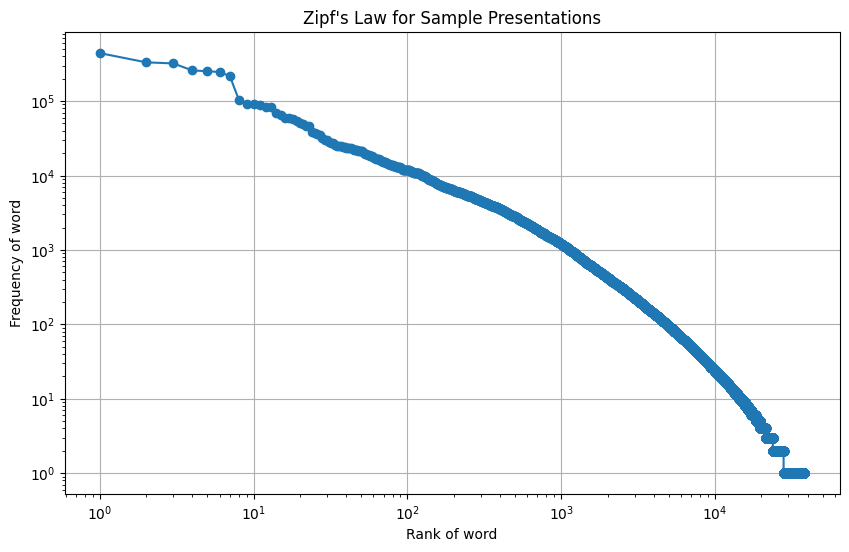

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming dtm is a Pandas DataFrame with word frequencies
word_counts = dtm.sum().sort_values(ascending=False)  # Sum frequencies and sort

# Convert to DataFrame for better handling
df_zipf = pd.DataFrame({'Word': word_counts.index, 'Frequency': word_counts.values})

# Add Rank
df_zipf['Rank'] = np.arange(1, len(df_zipf) + 1)

# Plot Zipf's Law
plt.figure(figsize=(10, 6))
plt.loglog(df_zipf['Rank'], df_zipf['Frequency'], marker='o')
plt.title("Zipf's Law for Sample Presentations")
plt.xlabel('Rank of word')
plt.ylabel('Frequency of word')
plt.grid(True)
plt.show()


## TF-IDF

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a numerical measure that helps us understand the importance of a word in a document relative to a collection of documents, also known as a corpus. This measure is crucial in text analysis and information retrieval.

**Components of TF-IDF:**
- **Term Frequency (TF):** This measures how frequently a term appears in a document. The more times a word appears in a document, the higher its TF value.
- **Inverse Document Frequency (IDF):** This measures how important a term is. While TF is about frequency, IDF is about rarity. If a word appears in many documents, its IDF is lower, indicating it is less unique.

The TF-IDF value is calculated by multiplying the TF and IDF values. A high TF-IDF score indicates that the term is very important to the document it appears in, and not common across the entire corpus.

**Visual Representation:**
Below is a visual representation of the TF-IDF formula:

<img src="http://www.tiesdekok.com/EAA_2018_NLP/images/TFIDF_equation.PNG" alt="TF-IDF Formula" width="500"/>

**Example of TF-IDF in Action:**
To better understand how TF-IDF works, consider the following example:

<img src="https://d1avok0lzls2w.cloudfront.net/uploads/blog/5445d032e97981.23456174.jpg" alt="TF-IDF Example" width="500"/>


**Why is TF-IDF Important?**
TF-IDF is essential because it helps identify the most relevant words in a document, which can be particularly useful for search engines, text classification, and topic modeling. By focusing on unique terms, TF-IDF enhances the ability to find meaningful patterns in text data.


In [ ]:
# Import TfidfVectorizer from scikit-learn to compute the TF-IDF matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True,use_idf=True)

# Transform the presentations into a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(Sample_Presentations['presentation'])

# Convert the TF-IDF matrix to a pandas DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the shape and the first few rows of the TF-IDF DataFrame
print(f"TF-IDF Matrix Shape: {tfidf_df.shape}")
tfidf_df.head()

TF-IDF Matrix Shape: (2876, 38133)


,00,000,000000007,000th,001,002,003,004,005,006,...,zyn,zyprexa,zytiga,zzzquil,zzzs,zürich,½me,élysées,éléonore,ørland
0,0.0,0.012297,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.004358,0.0,0.0,0.0,0.0,0.0,0.0,0.017433,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.004701,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.004099,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfidf_df.sum().sort_values(ascending=False).reset_index()

,index,0
0,the,1093.510496
1,and,823.407793
2,to,801.834063
3,of,641.682558
4,in,618.985643
...,...,...
38128,opcos,0.005390
38129,spreadsheet,0.005390
38130,yuck,0.005390
38131,fads,0.005390


In [ ]:
# Getting the top 10 terms with the highest TF-IDF values across all reviews
top_n = 20

# Sum the TF-IDF values for each term across all documents
tfidf_sums = tfidf_df.sum(axis=0)

# Get the top 10 terms with the highest TF-IDF sums
top_terms = tfidf_sums.nlargest(top_n)

# Display the top terms and their TF-IDF sums
print("Top 20 terms with the highest TF-IDF values:")
print(top_terms)


Top 20 terms with the highest TF-IDF values:
the        1093.510496
and         823.407793
to          801.834063
of          641.682558
in          618.985643
our         615.433402
we          536.179717
for         263.604780
quarter     238.729947
year        232.320136
on          221.195821
as          206.294844
with        204.178492
that        168.227211
this        165.010488
million     157.830133
is          146.400160
are         141.727456
by          135.968198
growth      129.191073
dtype: float64


In scikit-learn, the inverse document frequency (IDF) is computed as follows:

- **With smoothing enabled (default, i.e., `smooth_idf=True`):**  
   $
  \text{idf}(t) = \log\left(\frac{1 + n}{1 + \text{df}(t)}\right) + 1
   $
  Here,  $  n  $  is the total number of documents and  $  \text{df}(t)  $  is the number of documents containing term  $  t  $ .

- **With smoothing disabled (i.e., `smooth_idf=False`):**  
   $
  \text{idf}(t) = \log\left(\frac{n}{\text{df}(t)}\right) + 1
   $

This means that when `smooth_idf` is set to `False`, if a term appears in every document (i.e.,  $ \text{df}(t) = n $ ), its IDF becomes  $ \log(1) + 1 = 1 $ .

> Scikit-learn’s implementation of TF-IDF always includes the “+1” in the IDF calculation, and there isn’t a built-in parameter to remove it. This design choice helps prevent zero weights for terms that appear in every document. If you need an IDF without the additional one, you’d have to implement a custom transformer or manually compute TF-IDF with your desired formula.


#### Excercise: Custom TF-IDF

What would be the tf-idf of the term "the" according to $ TF * log(N / DF) $

> Hint: use the dtm matrix

In [ ]:
import math

# Assume dtm is your document-term matrix as a pandas DataFrame
# where each row is a document and each column is a term.

term = 'the'

# Total frequency of the term "the" across all documents.
tf = dtm[...]....

# Document frequency: number of documents where the term "the" appears at least once.
df = ...

# Total number of documents in the corpus.
n = ...

# Compute TF-IDF using your formula: TF * log(N / DF)
tf_idf_manual = ...

print(f'Manual TF-IDF for "{term}": {tf_idf_manual}')

Manual TF-IDF for "the": 460.5806645233465


TF-IDF is designed to automatically assign lower weights to words that appear very frequently across documents, which often includes stopwords. In theory, this means that stopwords naturally receive lower scores. However, there are practical reasons why many practitioners choose to drop stopwords before applying TF-IDF:

- **Noise Reduction:** Removing stopwords reduces the dimensionality of your data and minimizes noise, which can improve model performance and computational efficiency.
- **Interpretability:** Without stopwords, the resulting features are often more interpretable, focusing on words that carry more meaningful content.
- **Task Dependency:** In some tasks, especially those involving sentence structure or nuanced language patterns, stopwords might still carry some significance. In such cases, you might opt to retain them.

In summary, while TF-IDF does diminish the impact of stopwords, pre-removing them is usually beneficial for clarity and efficiency—unless your specific application requires their contextual contribution.

### TF-IDF Vectorizer Arguments and Stopword Removal

The `TfidfVectorizer` in scikit-learn offers several important arguments that influence how TF-IDF scores are calculated. Let's break down the ones mentioned:

- `lowercase=True`: Converts all text to lowercase before processing. This ensures that words like "The" and "the" are treated as the same word.
- `use_idf=True`: Enables inverse document frequency (IDF) weighting. IDF reduces the weight of common words and increases the weight of rare words.
- `smooth_idf=True`: Adds 1 to the document frequencies when calculating IDF, preventing division by zero and smoothing the IDF values.
- `stopwords="english"`: Removes common English stopwords (e.g., "the", "a", "is") from the text. Stopwords are frequent words that usually don't contribute much to the meaning of a document.

Removing stopwords is a crucial step in text analysis because it helps to focus on the more meaningful words in the corpus.  The following code demonstrates how to identify the top TF-IDF terms after stopword removal:

This code snippet first initializes a `TfidfVectorizer` with `stop_words='english'` to automatically remove English stopwords.  Then, it calculates the TF-IDF matrix, sums the TF-IDF values for each term across all documents, and prints the top N terms with the highest TF-IDF values.  This provides a clear view of the most important terms in your corpus after stop words have been filtered out.

In [ ]:
# Create a TF-IDF vectorizer with English stopwords removed
vectorizer = TfidfVectorizer(lowercase=True,stop_words='english')

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(Sample_Presentations['presentation'])

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Sum the TF-IDF values for each term across all documents
tfidf_sums = pd.DataFrame(tfidf_matrix.toarray(),columns=vectorizer.get_feature_names_out()).sum(axis=0)

top_n= 20
# Get the top 10 terms with the highest TF-IDF sums
top_terms = tfidf_sums.nlargest(top_n)

# Display the top terms and their TF-IDF sums
print("Top 20 terms with the highest TF-IDF values (excluding stopwords):")
print(top_terms)


Top 20 terms with the highest TF-IDF values (excluding stopwords):
quarter      378.967471
year         370.899044
million      248.346043
growth       206.826164
sales        144.974654
revenue      141.573534
business     123.832333
billion      104.139180
results      101.354708
new           97.388589
strong        96.644972
basis         95.494021
share         94.448006
operating     94.358835
expect        94.156995
cash          92.389475
continue      91.132356
second        90.817739
earnings      90.027885
adjusted      85.473931
dtype: float64


# NLP Applications: Textual Similiarity

## Cosine Similarity

### What is Cosine Similarity?
Cosine similarity is a measure that calculates the cosine of the angle between two vectors in a multi-dimensional space. It is commonly used in text analysis to compare the similarity between two documents.

### Formula

$\text{cosine similarity} = \frac{A \cdot B}{||A|| \times ||B||}$

where:
-  $  $A \cdot B $ $  is the dot product of vectors A and B.
-  $  ||A||  $  and  $  ||B||  $  are the magnitudes (norms) of the vectors.

## Why Use Cosine Similarity?
- **Independent of text length**: It focuses on the **direction** rather than magnitude.
- **Useful for text comparison**: Works well for **TF-IDF**-based vector representations.

#### In 2D
<img src="https://miro.medium.com/v2/resize:fit:488/0*4IVXlcZV8Sm29h79.png" alt="TF-IDF Example" width="500"/>

#### In 3D
<img src="https://i0.wp.com/spotintelligence.com/wp-content/uploads/2023/09/vector-space-model.jpg?fit=960%2C540&ssl=1" alt="TF-IDF Example" width="500"/>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sample documents
documents = [
    "Machine learning is a subset of artificial intelligence",
    "Artificial intelligence enables machines to learn from experience",
    "Deep learning is a part of machine learning focused on neural networks"
]

# Convert text into TF-IDF vectors
vectorizer = TfidfVectorizer(lowercase=True,use_idf=False, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Print the similarity matrix
import pandas as pd
df = pd.DataFrame(cosine_sim, index=["Doc1", "Doc2", "Doc3"], columns=["Doc1", "Doc2", "Doc3"])


In [ ]:
tfidf_matrix.toarray()

array([[0.4472136 , 0.        , 0.        , 0.        , 0.        ,
        0.4472136 , 0.        , 0.4472136 , 0.4472136 , 0.        ,
        0.        , 0.        , 0.4472136 ],
       [0.40824829, 0.        , 0.40824829, 0.40824829, 0.        ,
        0.40824829, 0.40824829, 0.        , 0.        , 0.40824829,
        0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.66666667, 0.33333333, 0.        ,
        0.33333333, 0.33333333, 0.        ]])

In [ ]:
df

,Doc1,Doc2,Doc3
Doc1,1.000000,0.365148,0.447214
Doc2,0.365148,1.000000,0.000000
Doc3,0.447214,0.000000,1.000000


#### **Discussion: Risk Measurement by Comparing with a Reference Document**

> To assess how much a financial document reflects a specific theme (e.g., innovation, climate change, ESG), we need a strong reference document that represents the theme well.  
>  
> **What would be an ideal reference document for measuring each of the following themes?**  
> 1. **Innovation**  
> 2. **Climate Change**  
> 3. **ESG (Environmental, Social, and Governance)**  
> 4. **Generative AI**  
> 5. **Geopolitical Risk**  
> 6. **Litigation Risk**


### **Exercise: Measuring Firms' Exposure to Climate Change**  

This exercise follows the approach detailed in [Engle et al. (2020, RFS)](https://academic.oup.com/rfs/article-abstract/33/3/1184/5735305).  

**Steps:**  
1. Compute **TF-IDF vectors** for key climate change reference documents, such as **IPCC reports**.  
2. Compute **TF-IDF vectors** for firms' **earnings call transcripts**.  
3. Compare the similarity between these vectors to assess **the extent of climate-related discussions** in firms' communications.  
4. List the highest and lowest similiarity companies.

This analysis helps quantify a firm's exposure to climate change themes based on its textual disclosures.

In [ ]:
# Step 0 (a): Download the IPCC reports and clean them

import os
import re

# Clone the repository
# !git clone https://github.com/morgwork/IPCC-Reports-PDF-TXT.git

# Base directory where the repository is cloned
base_directory =  "/content/IPCC-Reports-PDF-TXT/"

IPCCs= []
# Walk through all folders and subfolders
for root, dirs, files in os.walk(base_directory):
    for filename in files:
        if filename.endswith('.txt'):
            file_path = os.path.join(root, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
              filetxt = file.read()
              # Clean text using a single regex expression
              filetxt = re.sub(r'[\ufeff]|[\t\n\r]+|[^\x00-\x7F]+', ' ', filetxt).strip()
              IPCCs.append(filetxt)
        if len(IPCCs)>10:
            break



In [ ]:
# Step 0(b): Aggregate all the sections of earnings calls

# Group by file_name and concatenate presentation column
Pres = Sample_Presentations.groupby("file_name")["presentation"].agg(lambda x: " ".join(x)).reset_index()
Pres.columns= ["file_name","text"]

# Group by file_name and concatenate QA column
QA= Sample_QAs.groupby("file_name")["QA_text"].agg(lambda x: " ".join(x)).reset_index()
QA.columns= ["file_name","text"]

# Merge the two DataFrames on 'file_name' and aggregate the 'text' column
ECs = pd.merge(Pres, QA, on='file_name', suffixes=('_pres', '_qa'))

# Concatenate the text from both columns into a single column
ECs['text'] = ECs['text_pres'] + " " + ECs['text_qa']

# Drop the individual text columns if no longer needed
ECs.drop(columns=['text_pres', 'text_qa'], inplace=True)

**Now let't do the excercise**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Fit a TF-IDF vectorizer on the IPCCs text only
ipcc_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',min_df=10)
ipcc_tfidf = ipcc_vectorizer.fit_transform(IPCCs)  # IPCCs as a single document


In [ ]:
ipcc_tfidf.shape

(13, 3158)

In [ ]:

# Step 2: Use the vocabulary from the IPCCs to vectorize the ECs texts
ecs_vectorizer = TfidfVectorizer(lowercase=True,vocabulary=ipcc_vectorizer.vocabulary_)
ecs_tfidf = ecs_vectorizer.fit_transform(ECs['text'].tolist())



In [ ]:
ipcc_tfidf.shape
ecs_tfidf.shape

(2876, 3158)

In [ ]:
# Step 3: Compute cosine similarity between the IPCC document and each EC document
cosine_sim = cosine_similarity(ipcc_tfidf, ecs_tfidf)
cosine_sim.shape

(13, 2876)

In [ ]:
pd.DataFrame(cosine_sim).mean()

,0
0,0.174758
1,0.185424
2,0.182222
3,0.167004
4,0.176972
...,...
2871,0.170119
2872,0.187610
2873,0.170134
2874,0.148995


In [ ]:
# Step 4: Store the results in the ECs DataFrame
ECs['cosine_similarity'] = pd.DataFrame(cosine_sim).mean()
# Display the first few rows
ECs.head()
ECs.merge(Sample_EC).sort_values(by="cosine_similarity",ascending=False)

,file_name,text,cosine_similarity,GVKEY,date_rdq,co_conm,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,...,oiadpq,niq,epspxq,epspiq,dlttq,dlcq,prccq,cshoq,dvpq,xintq
2751,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,"Good morning, and welcome to the Q3 2020 C...",0.263221,8549.0,2020-10-29 16:00:00+00:00,CONOCOPHILLIPS,-0.039549,-0.034867,-0.034867,-0.018508,...,-291.000,-450.000,-0.42,-0.42,14905.000,482.000,32.84,1072.742,0.0,213.000
2836,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,Good morning to all. Our earnings anno...,0.251874,6216.0,2020-11-24 15:00:00+00:00,JACOBS ENGINEERING GROUP INC,-0.004886,-0.007353,-0.007353,0.001352,...,396.585,81.991,0.53,0.63,2412.143,164.312,92.77,129.748,0.0,14.131
2418,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,"Good afternoon, and welcome to WEC Energy ...",0.244104,11550.0,2020-01-30 19:00:00+00:00,WEC ENERGY GROUP INC,0.011974,0.005787,0.005787,0.013386,...,363.100,244.200,0.77,0.77,11248.000,1528.400,92.23,315.435,0.3,127.200
1738,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2019...,"Thank you, Laura. Good morning, everyo...",0.243355,8068.0,2019-02-13 17:00:00+00:00,OCCIDENTAL PETROLEUM CORP,0.021533,0.017383,0.017383,0.017293,...,873.000,706.000,0.93,0.93,10201.000,116.000,61.38,749.390,0.0,99.000
2824,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,"Thank you, Grant. Good morning, everyo...",0.243191,8068.0,2020-11-10 16:00:00+00:00,OCCIDENTAL PETROLEUM CORP,-0.037834,0.067075,0.067075,-0.040531,...,-132.000,-3575.000,-4.16,-4.07,36685.000,3017.000,10.01,931.386,203.0,353.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2019...,Thank you for joining us today. We...,0.101803,7922.0,2019-11-21 21:45:00+00:00,NORDSTROM INC,0.072768,0.083068,0.083068,0.110817,...,193.000,127.000,0.81,0.81,4574.000,238.000,35.90,155.200,0.0,20.000
580,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,Welcome to the Netflix Q2 2017 earnings ca...,0.101592,147579.0,2017-07-17 22:00:00+00:00,NETFLIX INC,0.141183,0.144231,0.144231,0.135753,...,127.807,65.600,0.15,0.15,4836.502,0.000,149.41,431.750,0.0,55.482
894,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,"Ladies and gentlemen, thank you for standi...",0.101399,10519.0,2017-01-25 13:00:00+00:00,TEXTRON INC,-0.037116,-0.035435,-0.035435,-0.026993,...,344.000,214.000,0.79,0.79,3253.000,427.000,48.56,270.287,0.0,42.000
2602,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,"Good afternoon, and thank you for join...",0.099096,7922.0,2020-05-28 20:45:00+00:00,NORDSTROM INC,-0.007748,-0.013776,-0.013776,-0.127752,...,-533.000,-521.000,-3.33,-3.33,5100.000,1043.000,18.78,157.000,0.0,34.000


In [ ]:
# Which companies have the most similiarity?
ECs.merge(Sample_EC).groupby('co_conm')['cosine_similarity'].mean().sort_values(ascending=False)

,cosine_similarity
co_conm,
OCCIDENTAL PETROLEUM CORP,0.213199
NEXTERA ENERGY INC,0.212004
JACOBS ENGINEERING GROUP INC,0.209630
MONSANTO CO,0.202669
COOPER COS INC (THE),0.198250
...,...
HESS CORP,0.133059
NORDSTROM INC,0.129344
TAKE-TWO INTERACTIVE SFTWR,0.128959


### Other Similarity Measures

In addition to cosine similarity, there are several other matrix-like similarity measures that can be used to compare documents or sets of data. These measures can provide different insights depending on the nature of the data and the specific requirements of the analysis.

**1. Jaccard Similarity:**

Jaccard similarity is a measure of the similarity between two sets. It is defined as the size of the intersection divided by the size of the union of the sets. This measure is particularly useful for binary or categorical data and is often used in text analysis to compare the similarity of two documents based on the presence or absence of words.

- **Formula:** J(A, B) = |A ∩ B| / |A ∪ B|
- **Use Case:** Comparing two documents to see how many words they have in common relative to the total number of unique words in both documents.
- **Example:** If Document A contains the words {apple, banana, cherry} and Document B contains {banana, cherry, date}, the Jaccard similarity is 2/4 = 0.5.

**2. Euclidean Distance:**

Euclidean distance is a measure of the true straight line distance between two points in Euclidean space. It is often used in clustering and classification tasks.

- **Formula:** d(A, B) = sqrt(Σ (Ai - Bi)^2)
- **Use Case:** Measuring the distance between two points in a multi-dimensional space, such as feature vectors in machine learning.

**3. Manhattan Distance:**

Also known as the L1 distance, it is the sum of the absolute differences of their coordinates. It is useful in high-dimensional spaces.

- **Formula:** d(A, B) = Σ |Ai - Bi|
- **Use Case:** Often used in optimization problems where the path is restricted to grid-based movement.

**4. Pearson Correlation:**

Pearson correlation measures the linear correlation between two sets of data. It is a value between -1 and 1, where 1 means total positive linear correlation, 0 means no linear correlation, and -1 means total negative linear correlation.

- **Formula:** r = Σ [(Ai - A_mean) * (Bi - B_mean)] / (n * σA * σB)
- **Use Case:** Understanding the relationship between two variables, such as in time series analysis.

Each of these measures has its own strengths and weaknesses, and the choice of which to use depends on the specific characteristics of the data and the goals of the analysis.

### Comparing Cosine and Jaccard Similarities

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
import numpy as np

# Example documents
doc1 = "The quick brown fox jumps over the lazy dog"
doc2 = "The fast brown fox leaps over the lazy dog"

# Step 2: Calculate term frequency vectors
vectorizer = CountVectorizer(binary=False)  # Use term frequencies
tf_matrix = vectorizer.fit_transform([doc1, doc2]).toarray()

# Step 3: Compute Cosine Similarity
cosine_sim = cosine_similarity(tf_matrix)[0, 1]

# Step 4: Compute Jaccard Similarity
# Convert term frequency vectors to binary presence/absence vectors
binary_matrix = (tf_matrix > 0).astype(int)


# # Compute Jaccard Similarity
intersection = np.logical_and(binary_matrix[0], binary_matrix[1]).sum()
union = np.logical_or(binary_matrix[0], binary_matrix[1]).sum()
jaccard_sim = intersection / union

# or more simply:
jaccard_sim = jaccard_score(binary_matrix[0], binary_matrix[1])



# Step 5: Print the results
print(f"Cosine Similarity: {cosine_sim:.4f}")
print(f"Jaccard Similarity: {jaccard_sim:.4f}")



Cosine Similarity: 0.8182
Jaccard Similarity: 0.6000


In [ ]:
# Sample documents
docs = ["data science is fun", "data science is fun and incredibly fascinating with numerous applications"]

# Compute TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs).toarray()

# Cosine similarity calculation
cos_sim = cosine_similarity(tfidf_matrix)[0, 1]
print("Cosine Similarity:", cos_sim)

tf_matrix = (vectorizer.fit_transform([doc1, doc2]).toarray() > 0 ) *1

jacc_sim = jaccard_score(tf_matrix[0], tf_matrix[1])
print("Jaccard Similarity:", jacc_sim)


Cosine Similarity: 0.5023287782256718
Jaccard Similarity: 0.6


## Discussion: Exploring the Relationship Between Cosine and Jaccard Similarity in Text Analysis


[Cohen et. al. (2020)](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.12885) use Jaccard similarity to check if the drop of certain words from annual reports between two years indicates bad news for a firm. Why have they not used cosine similarity?

---

The authors opted for Jaccard similarity because it focuses on the presence or absence of words rather than their frequency. Here’s why this approach is more suitable for their analysis:

- **Binary vs. Frequency-Based Comparison:**  
  - **Jaccard Similarity:**  
    - Treats documents as sets of unique words and calculates similarity as the ratio of shared words (intersection) to the total unique words (union).  
    - Ignores how frequently a word appears, making it ideal for detecting if key terms are simply present or absent.  
  - **Cosine Similarity:**  
    - Considers documents as term frequency vectors and measures the cosine of the angle between these vectors, thus incorporating word frequency and repetition.  
    - Can dilute the impact of subtle changes, as it blends the frequency information with the overall distribution of words.

- **Use Case Suitability:**  
  - Jaccard similarity is especially useful when the analysis aims to capture the mere presence or absence of critical terms. In the context of corporate disclosures, the removal or absence of specific words may carry significant meaning regarding a firm's performance, independent of how often those words appear.  
  - Cosine similarity, while effective for measuring the overall similarity in word usage patterns, may not highlight such binary changes as clearly because it is influenced by the magnitude of word frequencies.

Thus, by using Jaccard similarity, the study targets changes in vocabulary—specifically, whether important words are dropped from the reports—which can serve as a subtle yet potent indicator of adverse news for the firm.


---
# **Word Embeddings**


**What are Word Embeddings?**
- Dense vector representations of words.
- Typically range from 50 to 1000 dimensions.
- Composed of real-valued numbers.
- Generated using machine learning models.
- Learn the context of words from large text corpora.
- Capture semantic relationships between words.
- Unlike Document-Term Matrix (DTM), which is high-dimensional and sparse.

**Comparison with Document-Term Matrix:**
- DTM:
  - Represents words based on their presence in documents.
  - Does not capture semantic meaning or context.
  - Example: "The car is fast" vs. "The automobile is quick" appear dissimilar.
- Word Embeddings:
  - Understand context and relationships.
  - Words like "growth" and "expansion" have similar vector representations.

**Example:**
- "Growth" and "expansion" should have similar embeddings.
- "Leadership" and "management" should be close in vector space.

**Discussion Questions:**
- How do word embeddings capture more context compared to traditional methods like DTM in NLP?
- How do embeddings help in financial applications?

---


### Setup and Imports

Gensim is a robust library for natural language processing, particularly useful for creating word embeddings.
It provides efficient implementations of popular algorithms like Word2Vec and Doc2Vec.
These models help in capturing semantic relationships between words by learning from large text corpora.
Gensim's ability to handle large datasets and its ease of use make it a valuable tool for generating word embeddings.

In [6]:
%%capture
!pip uninstall -y numpy gensim scipy smart-open
!pip install numpy==1.25.2 scipy gensim smart-open
# After this, restart session (don't delete runtime)

In [ ]:
import gensim

from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess

# additional libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans




## Computing Embeddings

### Word2Vec
Word2Vec [Mikolov et al., 2013] is one of the most well-known algorithms for constructing word embeddings.  
It relies on predicting the presence/absence of words within a local context.

### Two Variants:
- **Skip-gram model**: aims to predict the **context words** given a target word.  
- **Continuous Bag of Words (CBOW) model**: aims to predict a **target word** based on the context words.


<img src="https://i0.wp.com/spotintelligence.com/wp-content/uploads/2023/12/continuous-bag-of-words-vs-skip-gram-1.jpg?fit=1200%2C675&ssl=1&resize=1280%2C720" alt="TF-IDF Example" width="600"/>


---

### Skip-gram with Negative Sampling

### Intuition of Skip-gram:
- Self-supervised, using the actual appearances of words in the corpus.
- Randomly sample other words in the document (not close to the target word) to get negative samples.
- Use logistic regression to train a classifier to distinguish positive versus negative cases.
- The learned classifier **weights** are the word embeddings.

---

### The Classifier

### Example Sentence:
Consider the following sentence:

... lemon, a [ tablespoon of apricot jam, a ] pinch ...

Context window: `c1, c2, w, c3, c4`

### Training Objective:
- Train a classifier such that, given a tuple **(w, c)** (e.g., (apricot, jam) or (apricot, EDHEC)),  
  it returns the probability that **c** is a real context word:  
  $
  P(+ \mid w, c)
  $
- Compute probability based on **embedding similarities** or their **dot product**:
  $
  \text{Similarity}(w, c) \approx \mathbf{c} \cdot \mathbf{w}
  $
- Convert the dot product to probability using the logistic (sigmoid) function:
  $
  P(+ \mid w, c) = \sigma(\mathbf{c} \cdot \mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{c} \cdot \mathbf{w})}
  $

---

### Sigmoid and Probability

- The sigmoid function returns a value between **0 and 1**, but to make it a probability,  
  the sum of two possible events should be **1**:
  $
  P(- \mid w, c) = 1 - P(+ \mid w, c) = \sigma(\mathbf{-c} \cdot \mathbf{w}) = \frac{1}{1 + \exp(\mathbf{c} \cdot \mathbf{w})}
  $
- Since there are many context words in a window, Skip-gram assumes they are **independent**,  
  allowing us to compute the probability for a full context window of length **L**:
  $
  P(+ \mid w, c_{1:L}) = \prod_{i=1}^{L} \sigma(\mathbf{c}_i \cdot \mathbf{w})
  $
  $
  \log P(+ \mid w, c_{1:L}) = \sum_{i=1}^{L} \log \sigma(\mathbf{c}_i \cdot \mathbf{w})
  $

---

### Learning Embeddings

### Algorithm Steps:
1. Takes as input a **corpus of text** and a chosen **vocabulary size**  $ N $ .
2. Begins by assigning a **random embedding vector** for each of the  $ N $  vocabulary words.
3. Iteratively shifts the embedding of each word  $ w $  to be **more (or less) like**  
   the embeddings of words that **do (or don’t) occur nearby in text**.

---


<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*7vGADGPkreaBsxhSTmcgOw.png" alt="One-hot ecnoders" width="600"/>

#### Summary:
- Word2Vec learns **dense vector representations** for words.
- Skip-gram predicts **context words** from a **target word**.
- Uses **negative sampling** and **logistic regression** to train embeddings.
- The trained **word embeddings** capture **semantic relationships**.



## Convert Corpus to Sentences

For word2vec, it's generally best to break your text down into sentences rather than using whole documents. Here's why:

- **Local Context is Key:**  
  Word2vec relies on a sliding window over a sequence of tokens to capture local contextual relationships. When you break your text into sentences, the words within each sentence are more likely to be contextually related. This helps the model learn more accurate word associations.

- **Avoiding Unrelated Contexts:**  
  If you use entire documents—especially long ones—the context window might span across different topics or sentence boundaries. This can mix unrelated words together and potentially reduce the quality of your embeddings.

- **Implementation Expectations:**  
  Many word2vec implementations, like Gensim’s Word2Vec, are designed to work with lists of sentences (each sentence being a list of tokens). Using sentences ensures that the data is structured in a way that the algorithm expects, which can lead to better performance.

In summary, while you might get acceptable results using documents in some cases (especially if your documents are short and cohesive), breaking your text into sentences is typically the more effective approach for capturing the true semantic relationships between words.

In [ ]:
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt_tab')
import re

def preprocess(text):
    """Tokenize the text into sentences, strip whitespace, remove punctuation, and convert to lowercase."""
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    # Remove punctuation, strip whitespace, and convert to lowercase for each sentence
    processed_sentences = [re.sub(r'[^\w\s]', '', sentence).strip().lower().split() for sentence in sentences]
    return processed_sentences

# Tokenize the corpus and flatten the list of sentences
sentences = [sentence for doc in Sample_Presentations.presentation for sentence in preprocess(doc)]
print("Sample sentence:", sentences[0])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Sample sentence: ['good', 'day', 'and', 'welcome', 'to', 'the', 'linear', 'technology', 'corporation', 'fiscal', '2016', 'third', 'quarter', 'earnings', 'conference', 'call']



## Training Word2Vec

Let'd do the training on the Earnings Calls Corpus.

We will train a Word2Vec model using the Skip-gram approach (`sg=1`).


In [ ]:

# Train the Word2Vec model on the sampled sentences
model = Word2Vec(sentences, vector_size=130, window=5, min_count=10, workers=4, sg=1,)
print("Vocabulary size:", len(model.wv.index_to_key))
print("Vocabulary words:", model.wv.index_to_key)

Vocabulary size: 15759
Vocabulary words: ['the', 'and', 'to', 'of', 'in', 'our', 'we', 'a', 'for', 'quarter', 'year', 'on', 'as', 'with', 'that', 'this', 'is', 'million', 'are', 'by', 'growth', 'from', 'was', 'will', 'were', 'at', 'over', 'be', 'have', 'which', 'sales', 'business', 'an', 'revenue', 'us', 'you', 'first', 'more', 'new', 'i', 'now', 'results', 'up', 'well', 'also', 'billion', 'call', 'strong', 'expect', 'continue', 'share', 'these', 'operating', 'basis', 'earnings', 'second', 'cash', 'last', 'than', 'or', 'all', 'increased', 'it', 'approximately', 'per', 'market', 'net', 'performance', 'financial', 'about', 'adjusted', 'full', 'margin', 'has', 'third', 'customers', 'increase', 'through', 'impact', 'rate', 'higher', 'guidance', 'capital', 'points', 'while', 'during', 'driven', '2018', 'fourth', 'gaap', 'including', 'end', 'lower', 'both', 'continued', '2019', 'good', '2017', 'across', 'tax', '2', 'cost', 'forward', 'slide', 'flow', 'turn', 'other', 'so', 'due', 'expected',

In [ ]:
model.wv['queen']

KeyError: "Key 'queen' not present"

## Post Training Word Analogy
One interesting finding for the Word2Vec model is that it embeds some analogical relationships between words. \\
<br>
*Man is to Woman as King is to Queen* \\
Man - Woman = King - Queen \\
<br>
*Paris is to France as Madrid is to Spain* \\
Paris - France = Madrid - Spain \\
<br>
These relationships can be reconstructed using word embeddings. \\
<br>
![analogy](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/06062705/Word-Vectors.png)

In [ ]:
# word analogy example using gensim
# king is to man as what is to woman?

# resulting vector using gensim's most_similar
result = model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

# print the result
print("Most similar word to 'king' - 'man' + 'woman':", result[0][0])

# Dow we have queen even in our vocabs?

Most similar word to 'king' - 'man' + 'woman': blizzard


**Example in the finance world:**



In [ ]:
# "growth" is to "decline" as "stock" is to what?
# model.wv.most_similar(positive=['stock', 'growth'], negative=['decline'], topn=5)
model.wv.most_similar(positive=['company', 'ceo'], negative=['country'], topn=5)

[('chairman', 0.5543810129165649),
 ('executive', 0.5311886668205261),
 ('chief', 0.5233779549598694),
 ('allman', 0.5123057961463928),
 ('president', 0.5068759322166443)]

**Find the most similiar words to a word**

In [ ]:
model.wv.most_similar(['stock'], topn=5)

[('shares', 0.7104828357696533),
 ('repurchase', 0.6592681407928467),
 ('compensation', 0.6565394401550293),
 ('vesting', 0.6349878311157227),
 ('common', 0.6346879601478577)]

# Seed Expansion and Custom Dictionary Creation

In the world of natural language processing, one powerful technique is to expand a small set of `seed words` into a larger set of related words. This process is known as seed expansion. By identifying words that are most similar to our initial seed words, we can create a custom dictionary that captures the nuances and variations of a particular concept or theme.

For example, if we start with a seed word like "growth," we can use word embeddings to find other words that are closely related, such as "expansion," "increase," or "development." These related words can then be added to our custom dictionary.

Once we have our expanded dictionary, we can perform dictionary analysis. This involves using the dictionary to analyze text data, identifying the presence and frequency of the words in our dictionary. This can be particularly useful in fields like finance, where understanding the language and sentiment around concepts like "growth" or "decline" can provide valuable insights.

By leveraging seed expansion and custom dictionary creation, we can enhance our text analysis capabilities and gain a deeper understanding of the language used in specific domains.


In [ ]:

seed_word = "growth"
if seed_word in model.wv:
    similar_words = model.wv.most_similar(seed_word, topn=20)
    print(f"Words similar to '{seed_word}':")
    for word, similarity in similar_words:
        print(f" - {word}: {similarity:.4f}")
else:
    print(f"'{seed_word}' not found in the vocabulary.")


Words similar to 'growth':
 - organic: 0.5822
 - grow: 0.5809
 - endoscopy: 0.5746
 - digit: 0.5725
 - double: 0.5693
 - modality: 0.5625
 - grew: 0.5466
 - defib: 0.5421
 - inorganically: 0.5418
 - nontrading: 0.5401
 - gains: 0.5346
 - rps: 0.5322
 - revenue: 0.5293
 - epf: 0.5271
 - decline: 0.5230
 - increase: 0.5199
 - idps: 0.5198
 - igam: 0.5192
 - growing: 0.5155
 - cag: 0.5140




#### **Discussion: Measuring Key Trends Using Seed Expansion**  

- What would be an ideal "seed" or initial reference point for measuring trends in **innovation, climate change, ESG (Environmental, Social, and Governance), Generative AI, geopolitical risk, and litigation risk**?  

- How many seed words are **optimal**?

- Discuss the importance of language modeling, e.g. n-grams?

- How can the selection of an appropriate seed influence the accuracy and relevance of measurement outcomes in these areas?  




#### **Exercise: Measuring Corporate Culture Using Machine Learning (Li et al, 2021 RFS)**

In this exercise, inspired by the study "Measuring Corporate Culture Using Machine Learning" by Kai Li, Feng Mai, Rui Shen, and Xinyan Yan, published in The Review of Financial Studies, you will explore the concept of measuring corporate culture using word embeddings.

You are provided with a list of culture dimensions and a dictionary of seed words for each dimension.

DIMS = ["integrity", "teamwork", "innovation", "respect", "quality"]

SEED_WORDS is a dictionary that contains seed words for each dimension.

**Task:**
1. Use the provided word embedding model to find the average embedding for each culture dimension using the seed words.
2. Identify the 300 words closest to each average embedding.
3. Which companies are the highest in each culture dimension?

**Questions to Consider:**
- Is selecting 300 words a good idea given our smaller language model? Why or why not?
- What are the advantages of averaging the embeddings of seed words compared to expanding each seed word individually?
- Does using a larger group of seed words improve the accuracy of the results? Provide reasoning for your answer.

Use these questions to guide your analysis and provide a detailed explanation of your findings.

Reference: Li, K., Mai, F., Shen, R., & Yan, X. (2021). Measuring Corporate Culture Using Machine Learning. The Review of Financial Studies, 34(7), 3265–3315. https://doi.org/10.1093/rfs/hhaa079


In [ ]:
# Step 0: Inputs for constructing the expanded dictionary
DIMS = ["integrity", "teamwork", "innovation", "respect", "quality"]
SEED_WORDS = {
    "integrity": [
        "integrity",
        "ethic",
        "ethical",
        "accountable",
        "accountability",
        "trust",
        "honest",
        "honestly",
        "fairness",
        "responsibility",
        "responsible",
        "transparency",
        "transparent",
    ],
    "teamwork": [
        "teamwork",
        "collaboration",
        "collaborate",
        "collaborative",
        "cooperation",
        "cooperate",
        "cooperative",
    ],
    "innovation": [
        "innovation",
        "innovate",
        "innovative",
        "creativity",
        "creative",
        "create",
        "passion",
        "passionate",
        "efficiency",
        "efficient",
        "excellence",
        "pride",
    ],
    "respect": [
        "talent",
        "talented",
        "employee",
        "empowerment",
        "empower",
    ],
    "quality": [
        "quality",
        "customer",
        "dedication",
        "dedicated",
        "dedicate",
    ],
}


In [ ]:
# Step 1: Calculate the embedding average for each dimension
Expanded_Dictionary = {}

for dim in DIMS:
  # mean of model.wv[word] vectors
  temp_dim = np.mean([model.wv[word] for word in SEED_WORDS[dim]], axis=...)
  # Step 2: most close words to temp_dim
  similar_words = model.wv.similar_by_vector(temp_dim, topn=...)
  Expanded_Dictionary[dim] = [word for word, w in similar_words if w>...]


In [ ]:
Expanded_Dictionary['integrity']

['fairness',
 'ingrained',
 'utmost',
 'steward',
 'ethics',
 'core4',
 'obsessed',
 'professionalism',
 'accountable',
 'grit',
 'exemplary',
 'transparently',
 'socially',
 'accountability',
 'entrusted',
 'singularly',
 'passions',
 'understands',
 'pride',
 'teamwork',
 'privacy',
 'tenacity',
 'advocacy',
 'organize']

In [ ]:
# Step 3: Count the frequency of Expanded dic in earnings calls

def sentiment(text, word_list):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) #keep only words
    count = 0
    for word in word_list:
        count += text.count(word)
    return count/len(text.split())


for dim in DIMS:
  print(dim+'...')
  ECs['culture_'+dim] = ECs['text'][:20].apply(lambda x: sentiment(x, Expanded_Dictionary[dim]))


integrity...
teamwork...
innovation...
respect...
quality...


In [ ]:
ECs.head()

,file_name,text,culture_integrity,culture_teamwork,culture_innovation,culture_respect,culture_quality
0,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Ladies and gentlemen, thank you for standi...",0.000000,0.000108,0.000325,0.000000,0.000000
1,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to the Prudential quarterly earnin...,0.000000,0.000110,0.000220,0.000110,0.000000
2,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Ladies and gentlemen, thank you for standi...",0.000113,0.000113,0.000339,0.000000,0.000000
3,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Ladies and gentlemen, thank you for standi...",0.000079,0.000872,0.001189,0.000079,0.000079
4,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Ladies and gentlemen, thank you for standi...",0.000000,0.000615,0.000923,0.000000,0.000000


## Visualizing Word Embeddings
Word vectors in our model have 130 dimensions, which makes direct visualization impossible.
To visualize these high-dimensional vectors, we first need to reduce their dimensions.
We will use a technique called [t-SNE](https://lvdmaaten.github.io/tsne/), which stands for
t-Distributed Stochastic Neighbor Embedding. t-SNE is a non-linear dimensionality reduction
technique that is particularly well-suited for embedding high-dimensional data into a
low-dimensional space of two or three dimensions. It is popular for reducing dimensions
while preserving the local structure of the data, making it easier to visualize clusters
and patterns.

One of the key parameters in t-SNE is 'perplexity', which can be thought of as a
smooth measure of the effective number of neighbors. It is a crucial parameter that
balances attention between local and global aspects of your data. A smaller perplexity
focuses more on local data structure, while a larger perplexity captures a broader
global structure. The choice of perplexity can significantly affect the resulting
visualization, and it often requires some experimentation to find the optimal value.

Alternatively, you can use PCA (Principal Component Analysis), which is a linear
dimensionality reduction technique that transforms the data to a new coordinate system
such that the greatest variance by any projection of the data comes to lie on the first
coordinate (called the first principal component), the second greatest variance on the
second coordinate, and so on.

After reducing the dimensions to 2D, we can plot the words from our word analogy example
to visually identify patterns or clusters. This visualization can help in understanding
the relationships and similarities between different words in the context of the model.

For an interactive experience, you can explore word embeddings using this tool:
[TensorFlow Embedding Projector](https://projector.tensorflow.org/), which allows you
to visualize high-dimensional data in a web-based interface.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# use t-SNE to do dimension reduction, from 130d to 2d
# Set perplexity to a value less than the number of samples (10 in this case)
tsne_model = TSNE(n_components=2)

# get transformed vectors using gensim model.wv for a larger set of finance-related words
data = np.array([
    model.wv['stock'], model.wv['market'], model.wv['investment'], model.wv['equity'],
    model.wv['finance'], model.wv['trading'], model.wv['portfolio'], model.wv['asset'],
    model.wv['liability'], model.wv['capital'], model.wv['dividend'], model.wv['bond'],
    model.wv['interest'], model.wv['credit'], model.wv['debt'], model.wv['currency'],
    model.wv['inflation'], model.wv['revenue'], model.wv['profit'], model.wv['loss'],
    model.wv['economy'], model.wv['growth'], model.wv['risk'], model.wv['valuation'],
    model.wv['yield'], model.wv['hedge'], model.wv['derivative'], model.wv['option'],
    model.wv['futures'], model.wv['commodity'],  model.wv['liquidity'],
    model.wv['volatility'], model.wv['index'], model.wv['benchmark'], model.wv['securities'],
    model.wv['fund'], model.wv['merger'], model.wv['acquisition'], model.wv['leverage'],
    model.wv['earnings'], model.wv['diversification'], model.wv['regulation']
])
data_2d = tsne_model.fit_transform(data)

# Show all words in the graph
labels = ['stock', 'market', 'investment', 'equity', 'finance', 'trading', 'portfolio', 'asset', 'liability', 'capital',
          'dividend', 'bond', 'interest', 'credit', 'debt', 'currency', 'inflation', 'revenue', 'profit', 'loss',
          'economy', 'growth', 'risk', 'valuation', 'yield', 'hedge', 'derivative', 'option', 'futures', 'commodity',
           'liquidity', 'volatility', 'index', 'benchmark', 'securities', 'fund', 'merger', 'acquisition',
          'leverage', 'earnings', 'diversification', 'regulation']



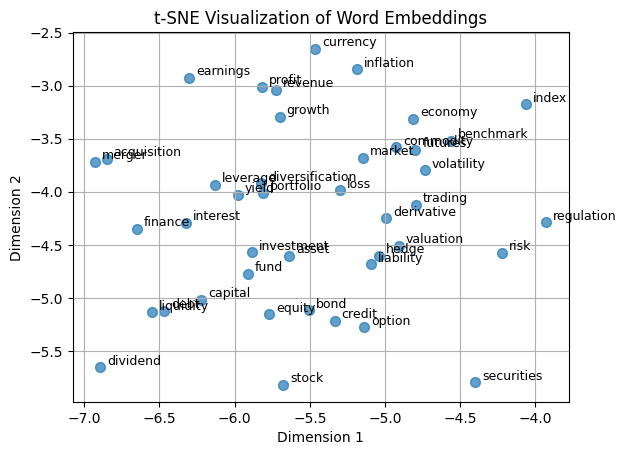

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure with a specific size.
# Do not use variable names like 'figure' that conflict with plt.figure.
fig = plt.figure#figsize=(12, 8))

# Plot the 2D vectors using scatter plot
plt.scatter(data_2d[:, 0], data_2d[:, 1], s=50, alpha=0.7)

# Annotate each point with its corresponding label
for i, word in enumerate(labels):
    plt.annotate(word, (data_2d[i, 0], data_2d[i, 1]),
                 xytext=(5, 2), textcoords='offset points', fontsize=9)

# Add titles and labels
plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)

# Show the plot
plt.show()

### Sentence/Document Level Similarity
Using word embeddings, we can also calculate similarity between sentences and documents. More advanced models such as Doc2Vec or neural networks can be used, but in this tutorial we will continue to use Word2Vec model to calculate document similarity. Since sentences and documents are composed of words, one easy way to obtain vector representations for sentences/documents is to calculate the average vectors of words.


Let's try to calculate the similarity among these three sentences:


 Example sentences in the context of finance
 1.   The stock market is volatile.
 2.   Investors are cautious about equities.
 3.   The median man earns more.



In [ ]:
# Word2Vec model does not provide vector representations for sentences
# or documents. How is the similarity between sentences computed?
# Since sentences are composed of words, an easy way to obtain the vector
# representations of sentences is by averaging the vectors of each word in
# the sentence.

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example sentences in the context of finance
s1 = (model.wv['the'] + model.wv['stock'] + model.wv['market'] + model.wv['is'] + model.wv['volatile']) / 5
s2 = (model.wv['investors'] + model.wv['are'] + model.wv['cautious'] + model.wv['about'] + model.wv['equities']) / 5
s3 = (model.wv['the'] + model.wv['average'] + model.wv['man'] + model.wv['earn'] + model.wv['more'])  / 5

# Reshape vectors to 2D arrays for sklearn's cosine_similarity
s1 = s1.reshape(1, -1)
s2 = s2.reshape(1, -1)
s3 = s3.reshape(1, -1)

print("Cosine similarity between s1 and s2:", cosine_similarity(s1, s2)[0][0])
print("Cosine similarity between s1 and s3:", cosine_similarity(s1, s3)[0][0])


Cosine similarity between s1 and s2: 0.63240933
Cosine similarity between s1 and s3: 0.5754959



## Using Pre-Trained Word Embeddings

In the realm of natural language processing, word embeddings are a crucial component for understanding and processing human language. They are dense vector representations of words that capture semantic meanings, relationships, and contexts. Training word embeddings from scratch can be computationally expensive and time-consuming, especially when dealing with large datasets. This is where pre-trained word embeddings come into play. Pre-trained word embeddings are models that have been previously trained on extensive corpora, such as Wikipedia or news articles, and are readily available for use. These embeddings encapsulate a wealth of linguistic information and can be directly applied to various NLP tasks, saving both time and computational resources.





**Stanford GloVe Model**:

 The Stanford GloVe (Global Vectors for Word Representation) model is a popular word embedding technique developed by researchers at Stanford University. It is designed to capture the semantic relationships between words by analyzing the global word-word co-occurrence statistics from a large corpus. Unlike other models that rely on local context, GloVe constructs a word vector space where the geometric relationships between words reflect their semantic similarities and differences. This model is particularly effective for tasks that require understanding the nuanced meanings and relationships between words, making it a valuable tool in natural language processing applications.

In [ ]:
import gensim.downloader as api

# This downloads the GloVe embeddings (100-dimensional) trained on Wikipedia and Gigaword.
glove_model = api.load("glove-wiki-gigaword-100")


# Print the most similar words to 'finance'
print(glove_model.most_similar('finance', topn=5))


[==================================================] 100.0% 128.1/128.1MB downloaded
[('banking', 0.7193476557731628), ('foreign', 0.7031715512275696), ('minister', 0.6959876418113708), ('financial', 0.6851174831390381), ('commerce', 0.6667627692222595)]


In [ ]:
glove_model.most_similar('kings', topn=5)

[('monarchs', 0.6545818448066711),
 ('devils', 0.6543017625808716),
 ('warriors', 0.6459389925003052),
 ('rangers', 0.6114345192909241),
 ('king', 0.6055065393447876)]

**Google's Pre-Trained Word2Vec Model**

Google-news trained on a massive corpus—the Google News dataset, which contains roughly 100 billion words. The pre-trained model provides 300-dimensional vectors for about 3 million words and phrases, capturing semantic relationships such that operations like:

  **vec("king") – vec("man") + vec("woman") ≈ vec("queen")**

work as expected.

You can easily load this model using the gensim library. For example:

A few key points about Google’s word2vec model:
- **Size:** The compressed file is around 1.5GB; uncompressed, it’s even larger (around 3.4GB), so you’ll need sufficient memory.
- **Training Data:** It was trained on the Google News corpus, which provides a broad and general representation of English.
- **Usage:** Because it’s pre-trained, it’s very useful for tasks like measuring word similarity, finding analogies, or as initialization for further training in downstream NLP tasks.


In [ ]:


# Load Google's pre-trained Word2Vec model
 google_model = api.load("word2vec-google-news-300")

# Example: find similar words to "king"
print(google_model.most_similar("king", topn=5))

NameError: name 'google_model' is not defined

In [ ]:
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)


[('queen', 0.7118193507194519),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133)]

---
### **Discussion**

What are the pros and cons of using a pre-trained model vs. training our own model?




---

## **Fine-tuning a pre-trained model**

Fine-tuning a pre-trained Word2Vec model (like Google's "word2vec-google-news-300") on additional documents is possible using incremental training, but there are a few important considerations:

1. **Vocabulary Updates:**  
   - The pre-trained model already has a fixed vocabulary.  
   - If your additional documents contain words **already in the vocabulary**, you can update the model’s weights using further training.  
   - If your documents include **new words**, you can add them by calling `build_vocab(new_sentences, update=True)`, but be cautious: adding many new words or significant vocabulary shifts may destabilize the model or produce suboptimal embeddings.

2. **Data Size and Domain:**  
   - Fine-tuning is most effective when your additional corpus is sufficiently large and similar in domain to the original training data.  
   - A small or very different corpus might not produce meaningful improvements, or it may even harm the quality of the original embeddings.

3. **Training Parameters:**  
   - Make sure to adjust parameters like the learning rate appropriately during fine-tuning.  
   - You can use the same number of epochs as used in the original training, or experiment with lower values to avoid overfitting to the new corpus.

### Example Code

Below is an example of how you might fine-tune the Google News Word2Vec model with additional tokenized sentences:

```python
import gensim.downloader as api

# Load Google's pre-trained Word2Vec model
google_model = api.load("word2vec-google-news-300")

# Example: find similar words to "king" before fine-tuning
print("Before fine-tuning:")
print(google_model.most_similar("king", topn=5))

# Assume new_sentences is a list of tokenized sentences, e.g.,
new_sentences = [
    ["this", "is", "a", "sample", "sentence"],
    ["another", "example", "document"],
    # Add more tokenized sentences as needed...
]

# Update the vocabulary with new sentences (only adds words not already in the model)
google_model.build_vocab(new_sentences, update=True)

# Fine-tune the model using the new sentences
google_model.train(new_sentences, total_examples=len(new_sentences), epochs=google_model.epochs)

# Check similar words to "king" after fine-tuning
print("\nAfter fine-tuning:")
print(google_model.most_similar("king", topn=5))
```

### Additional Tips

- **Preprocessing:**  
  Make sure your sentences are preprocessed in the same way as the original training data (e.g., tokenization, lowercasing if needed) to maintain consistency.

- **Monitoring:**  
  After fine-tuning, monitor how the embeddings change. It might be helpful to test on a set of known analogies or similarity tasks to ensure the updated embeddings remain useful.

- **Experimentation:**  
  You may want to experiment with different numbers of epochs or adjust the learning rate during fine-tuning to see what works best for your corpus.

By following these steps, you can effectively fine-tune a pre-trained Word2Vec model on your additional documents.

#### **Discussion**

Is word2vec optimal when we compare lenghty documents?



 # Using Doc2Vec


 Doc2Vec (also known as Paragraph Vector) is an extension of Word2Vec designed to learn fixed-length vector representations for larger bodies of text—like sentences, paragraphs, or entire documents. While Word2Vec focuses on individual words by predicting context words, Doc2Vec incorporates a unique document identifier (or “tag”) during training. This additional document vector is trained jointly with the word vectors to capture the overall context and semantics of the document.

### Key Differences from Word2Vec and Averaging Word Embeddings

- **Learning Document Representations Directly:**  
  Instead of deriving a document representation by simply averaging the embeddings of its words—a method that ignores word order and the interactions between words—Doc2Vec learns a vector specifically for each document. This vector is optimized to help predict words in the document, leading to richer representations.

- **Preserving Word Order and Context:**  
  Averaging word embeddings treats a document as a “bag of words,” discarding any notion of word order. In contrast, Doc2Vec (especially in its Distributed Memory (DM) model) uses the document vector alongside context words to predict a target word, which helps maintain some information about the order and structure of the text.

- **Two Main Approaches:**  
  - **Distributed Memory (DM):** Similar to the Continuous Bag-of-Words (CBOW) model in Word2Vec, this approach predicts a target word given both context words and a document identifier.  
  - **Distributed Bag of Words (DBOW):** This approach ignores context words during training and learns the document vector by predicting random words from the document (akin to a skip-gram model for documents).

In summary, while averaging word embeddings can be a simple baseline to represent a document, it often loses valuable context and structure. Doc2Vec provides a more nuanced representation by learning document-specific vectors that capture the broader semantics and word relationships within the text.



In [ ]:
import re
from nltk.tokenize import sent_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def preprocess(text):
    """
    Tokenize the text into sentences, remove punctuation, strip whitespace,
    convert to lowercase, and split into tokens.
    """
    sentences = sent_tokenize(text)
    processed_sentences = [re.sub(r'[^\w\s]', '', sentence).strip().lower().split()
                           for sentence in sentences]
    return processed_sentences

# Prepare your documents: each document gets converted to a list of tokens,
# and tagged with a unique ID.
documents = []
for idx, doc in enumerate(Sample_Presentations.presentation):
    # Flatten the document's sentences into one list of tokens
    tokens = [token for sentence in preprocess(doc) for token in sentence]
    # Create a TaggedDocument with a unique tag
    documents.append(TaggedDocument(words=tokens, tags=[f'DOC_{idx}']))

print("Sample document tokens:", documents[0].words)


Sample document tokens: ['good', 'day', 'and', 'welcome', 'to', 'the', 'linear', 'technology', 'corporation', 'fiscal', '2016', 'third', 'quarter', 'earnings', 'conference', 'call', 'todays', 'conference', 'is', 'being', 'recorded', 'at', 'this', 'time', 'i', 'would', 'like', 'to', 'turn', 'the', 'conference', 'over', 'to', 'don', 'zerio', 'vice', 'president', 'of', 'finance', 'and', 'chief', 'financial', 'officer', 'please', 'go', 'ahead', 'sir', 'good', 'morning', 'welcome', 'to', 'the', 'linear', 'technology', 'conference', 'call', 'im', 'joined', 'today', 'by', 'bob', 'swanson', 'our', 'executive', 'chairman', 'and', 'lothar', 'maier', 'our', 'ceo', 'i', 'would', 'like', 'to', 'remind', 'you', 'that', 'in', 'our', 'presentation', 'today', 'and', 'our', 'answers', 'to', 'certain', 'questions', 'that', 'may', 'follow', 'we', 'may', 'make', 'forward', 'looking', 'statements', 'that', 'are', 'dependent', 'on', 'certain', 'risks', 'and', 'uncertainties', 'including', 'but', 'not', 'limi

In [ ]:

# Create and train a Doc2Vec model
model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)


In [ ]:

# Retrieve the vector for the first document (using its tag)
doc_vector = model.dv['DOC_0']
print("Document vector for first document:", doc_vector)

# You can also infer a vector for a new, unseen document:
new_doc = "This is a new document that is not in the training data."
new_tokens = [token for sentence in preprocess(new_doc) for token in sentence]
inferred_vector = model.infer_vector(new_tokens)
print("Inferred document vector for new document:", inferred_vector)


Document vector for first document: [-1.4911908   1.1000482  -2.6902676  -0.3268475   1.4656904  -1.2016375
  1.4250187   1.414057   -2.2854457  -0.90926844  0.6152014   1.4075346
  4.1840754   0.64875895 -2.3636577  -2.417283   -1.5668232  -0.48201653
  1.5315381  -1.9358652  -1.6156498  -0.17449142  1.2839446  -1.4184157
  1.570629   -1.4357429  -1.2925124  -1.6731558   2.319236   -5.69799
  1.6189327  -1.5436757  -0.05361278 -0.9887566   0.7621185  -0.05967458
  1.856877   -3.3287919  -0.8417082  -1.9065981  -0.42186219 -0.02179805
 -0.33118573  0.9687442  -1.2807375   0.2120889  -0.24971986 -0.30158293
 -0.3485862  -1.5542514  -0.91336805  3.4285896   1.9980711  -1.3559073
 -2.4252043   0.2553563   2.6741831   0.9336162  -0.31191015  1.947276
  1.4917377   0.69060034  1.7764323   0.73131996 -1.1896149   1.3694166
  0.91448563 -0.02773444 -0.54496026 -1.6044081  -3.4666526   0.76334256
  1.3101989  -0.62731284  0.7642471  -0.14041509  0.9345762  -0.7642804
  1.5548744   0.5748885   

In [ ]:
# Define a function to find the closest document in the base dataset to a custom sentence
def find_closest_document(custom_sentence, model, documents):
    # Preprocess the custom sentence
    custom_tokens = [token for sentence in preprocess(custom_sentence) for token in sentence]
    # Infer the vector for the custom sentence
    custom_vector = model.infer_vector(custom_tokens)

    # Initialize variables to track the closest document and its similarity
    closest_document = None
    max_similarity = -1

    # Iterate over each document to find the closest one
    for idx, doc in enumerate(documents):
        # Retrieve the precomputed document vector
        doc_vector = model.dv[f'DOC_{idx}']
        # Calculate the similarity between the custom vector and the document vector
        similarity = cosine_similarity([custom_vector], [doc_vector])[0][0]

        # Update the closest document if the current one is more similar
        if similarity > max_similarity:
            max_similarity = similarity
            closest_document = ' '.join(doc.words)

    return closest_document, max_similarity

# Example usage
custom_sentence = "The market is recovering and we are optimistic about future growth."
closest_document, similarity, idx = find_closest_document(custom_sentence, model, documents)
print("Closest document:", closest_document)
print("Similarity score:", similarity)



Closest document: good afternoon and welcome to netflix q4 2019 earnings interview im spencer wang vp of ir and corporate development joining me today are ceo reed hastings cfo spence neumann chief content officer ted sarandos and chief product officer greg peters our interviewer this quarter is mike morris from guggenheim as a reminder well be making forward looking statements and actual results may vary with that let me turn it over to mike now for his first question
Similarity score: 0.7606301
